# Image Similarity Search with pgvector

This notebook demonstrates vector similarity search for marketplace images using PostgreSQL's pgvector extension with HNSW indexing:

- **KNN Search**: Finds visually similar images using L2 (Euclidean) distance on DINOv2 embeddings
- **HNSW Index**: Leverages Hierarchical Navigable Small World index for fast approximate nearest neighbor search
- **Visual Comparison**: Displays query image alongside top-k similar results with distance scores

The embeddings are pre-computed and stored in PostgreSQL. This notebook queries the database to retrieve and visualize similar images based on embedding proximity.

In [15]:
import os
import sys
from pathlib import Path

from dotenv import load_dotenv

notebooks_dir = Path().absolute()
project_dir = notebooks_dir.parent
os.chdir(project_dir)
load_dotenv()
sys.path.append(project_dir)

In [14]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from sqlmodel import Session, func, select

from dataset.const import DATA_ROOT
from dataset.db import ImageEmbedding, engine
from dataset.model import DinoV2WithNormalize

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [17]:
# Load model

warnings.filterwarnings("ignore", message="xFormers is available")
model = DinoV2WithNormalize()
model = model.to(device)
model.eval()
print("Model loaded.")

Model loaded.


### Test Similarity Search

Select a random image from the database

In [10]:
def select_random_image() -> ImageEmbedding:
    with Session(engine) as session:
        # Find 5 nearest neighbors
        random_image: ImageEmbedding|None = session.exec(
            select(ImageEmbedding)
            .order_by(func.random())
            .limit(1)
        ).first()
        assert random_image

    return random_image

Find similar images

In [11]:
def find_similar_images(query_image: ImageEmbedding) -> list[ImageEmbedding]:
    with Session(engine) as session:
        similar = session.exec(
            select(ImageEmbedding)
            .where(ImageEmbedding.image_path != query_image.image_path)
            .order_by(ImageEmbedding.embedding.l2_distance(query_image.embedding))
            .limit(19)
        ).all()

    return similar

In [12]:
def display_image_grid(image_paths: list[str], distances: list[float], cols=5):    
    figure = plt.figure(figsize=(8, 8))
    rows = (len(image_paths) + cols - 1) // cols
    for i in range(len(image_paths)):
        img = Image.open(DATA_ROOT.joinpath(image_paths[i]))
        figure.add_subplot(rows, cols, i + 1)
        if i==0:
            plt.title("Query")
        else:
            plt.title(
                f"Similar d={distances[i]:.3f}",
                fontsize=8, wrap=True
            )
        plt.axis("off")
        plt.imshow(img)
    plt.show()

#### L2 Distance Interpretation for Normalized Embeddings

| L2 Distance | Similarity | Interpretation |
|-------------|------------|----------------|
| 0.0 - 0.5   | Very high  | Nearly identical / same object |
| 0.5 - 1.0   | High       | Very similar images |
| 1.0 - 1.4   | Medium     | Somewhat similar |
| > 1.4       | Low        | Different images |


=== Query 1 ===


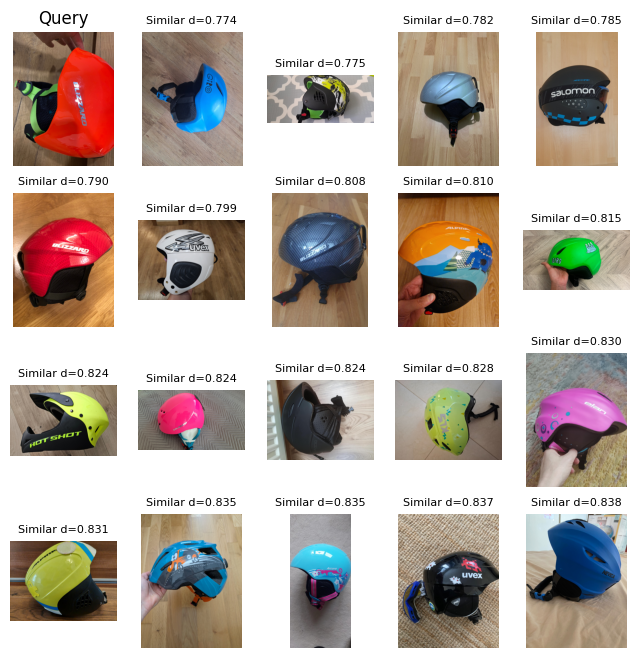


=== Query 2 ===


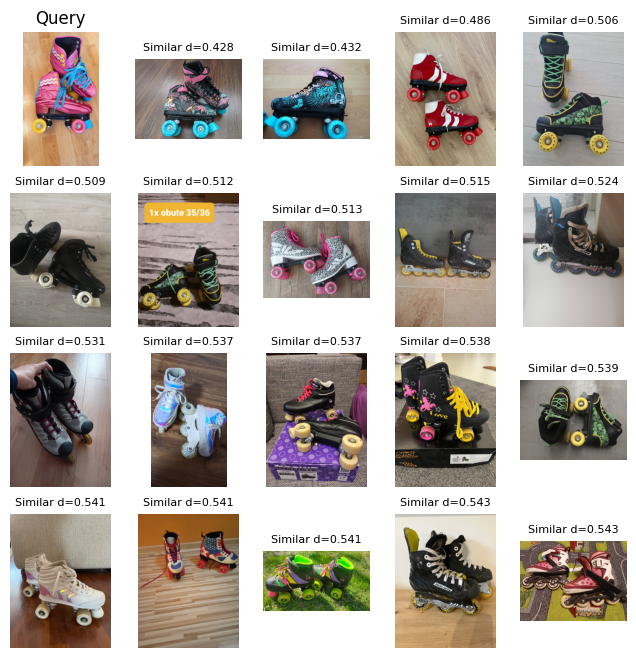


=== Query 3 ===


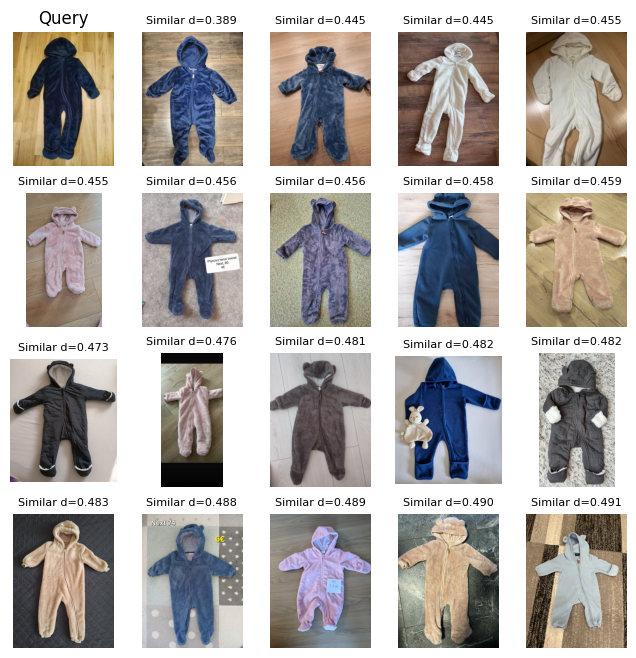


=== Query 4 ===


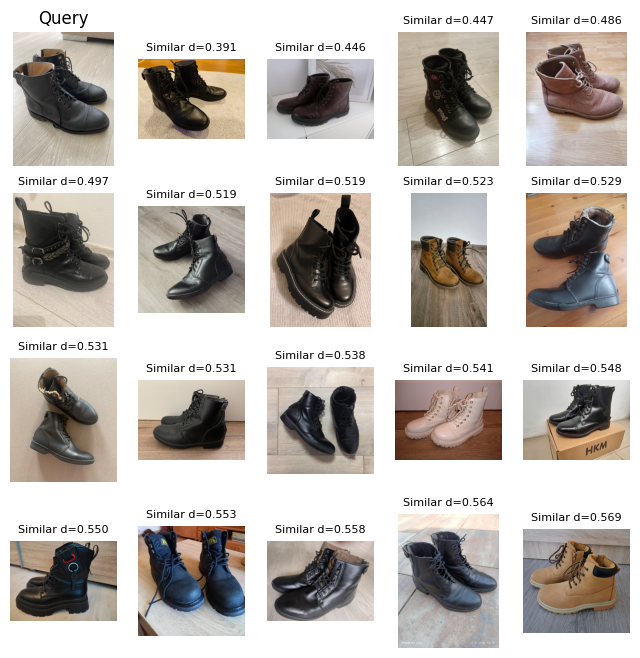


=== Query 5 ===


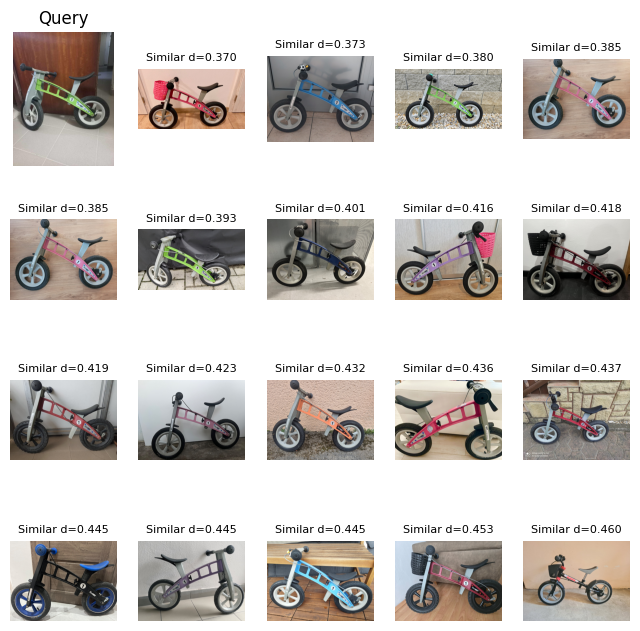

In [13]:
for i in range(5):
    print(f"\n=== Query {i+1} ===")
    query_image = select_random_image()
    similar = find_similar_images(query_image)

    image_paths = [query_image.image_path] + [ie.image_path for ie in similar]
    distances = [
        np.linalg.norm(np.array(query_image.embedding) - np.array(img.embedding))
        for img in [query_image] + similar
    ]
    display_image_grid(image_paths, distances)